In [1]:
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt

from load_compression_models import (
    my_bmshj2018_factorized, 
    my_bmshj2018_factorized_relu,
    my_bmshj2018_hyperprior,
    my_cheng2020_anchor,
    my_cheng2020_attn,
    my_mbt2018,
    my_mbt2018_mean
)
from sklearn.metrics.pairwise import cosine_similarity

def display_pil_img(img):
    plt.figure(figsize=(4, 4))
    plt.axis('off')
    plt.imshow(img)
    plt.show()

def display_tensor_img(img):
    plt.figure(figsize=(4, 4))
    plt.axis('off')
    plt.imshow(img.squeeze(0).permute(1, 2, 0).detach().cpu().numpy())
    plt.show()

def extract_features(model, dataloader, num_batches=100):
    features_list = []
    with torch.no_grad():
        for i, (images, _) in enumerate(dataloader):
            if i == num_batches:
                break
            features = model(images)
            features_list.append(features['y_hat'])
    return torch.cat(features_list, dim=0)

def feature_similarities(features):
    # Compute the similarities between the neural embeddings
    features_np = features.view(features.size(0), -1).numpy()
    similarities = cosine_similarity(features_np)
    return similarities

# Define the transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images to 256x256
    transforms.ToTensor(),  # Convert images to PyTorch tensors
])

# Load the CelebA dataset
dataset = datasets.CelebA(root='./data', split='train', transform=transform, download=True)

# Create a DataLoader
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4)

# Load the pretrained compression model
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda' 
elif torch.backends.mps.is_available():
    'mps'
models = {
    'my_bmshj2018_factorized_relu': my_bmshj2018_factorized_relu(quality=2, pretrained=True).train().to(device),
    'my_bmshj2018_factorized'     : my_bmshj2018_factorized(quality=2, pretrained=True).train().to(device),
    'my_bmshj2018_hyperprior'     : my_bmshj2018_hyperprior(quality=2, pretrained=True).train().to(device),
    'my_cheng2020_anchor'         : my_cheng2020_anchor(quality=2, pretrained=True).train().to(device),
    'my_cheng2020_attn'           : my_cheng2020_attn(quality=2, pretrained=True).train().to(device),
    'my_mbt2018'                  : my_mbt2018(quality=2, pretrained=True).train().to(device),
    'my_mbt2018_mean'             : my_mbt2018_mean(quality=2, pretrained=True).train().to(device)
}
net = models['my_bmshj2018_factorized']
print(f'Parameters: {sum(p.numel() for p in net.parameters())}')

# Compute similarities
features = extract_features(net, dataloader)
similarities = feature_similarities(features)

# Find most similar pairs
num_images = similarities.shape[0]
np.fill_diagonal(similarities, 0)  # Ignore self-similarity
most_similar = np.unravel_index(np.argmax(similarities, axis=None), similarities.shape)

# Print the most similar pairs
print(f"Most similar images indices are {most_similar[0]} and {most_similar[1]}")

Files already downloaded and verified
Parameters: 2998147
Most similar images indices are 1249 and 2599


In [2]:
img_1, img_2 = dataset[most_similar[0]][0], dataset[most_similar[1]][0]

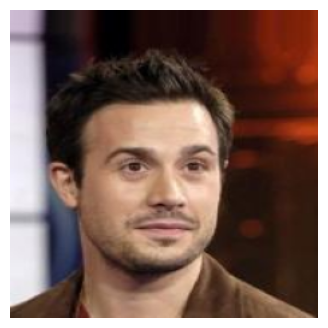

In [3]:
display_tensor_img(img_1)

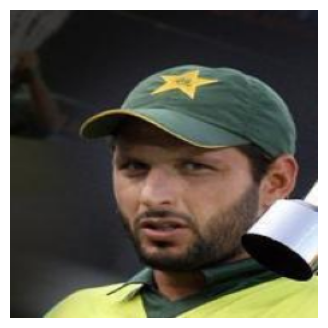

In [4]:
display_tensor_img(img_2)